In [4]:
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from datetime import datetime
from apyori import apriori
import lxml.etree as ET
import pandas as pd
import numpy as np
import unidecode
import html
import os
import re

# Import a dictionary with regular expressions
from utilities.regex_categories import * 

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define paths 

In [5]:
NEWS_PATH = 'data/news/'
INFO_FILE_PATH = 'data/cases_df.csv'

### Functions to read the dataset

In [6]:
def normalize_string(to_normalize, encoded = False, remove_stopwords = True):
    '''
    Normalize text given a string
    '''
    text = str(to_normalize).lower()  # lowering text
    if encoded: 
        text = ' '.join([html.unescape(term) for term in text.split()])
    text = unidecode.unidecode(text)

    text = re.sub(r'[^\w\s]', '', text)  # removing all the punctuations
    last_text = text.split()  # tokenize the text

    # remove stopwords
    stopwords_set = set()
    if remove_stopwords: stopwords_set = set(stopwords.words("spanish"))
    
    last_text = ' '.join([x for x in last_text if (x not in stopwords_set)])
    return last_text

def listdir_checked(path, unwanted = ['.DS_Store']):
    '''
    Discard unwanted files or directories when listing the elements in a given path
    '''
    return (f for f in os.listdir(path) if f not in unwanted)


def create_articles_dictionary(NEWS_PATH):
    '''
    Import articles information.
    Articles are stored in directories in the NEWS_PATH.
    '''
    data = {}               # keys: media, value: list of dictionaries with info about the news articles of the given media
    unique_urls = []        # list to store unique urls to discard repeated ones
    repeated_data = {}      # store repeated articles following the same format as 'data' dictionary

    for year in listdir_checked(NEWS_PATH):
        for month in listdir_checked(NEWS_PATH + '/' + year):
            for file in listdir_checked(NEWS_PATH + '/' + year + '/' + month):
                try:
                    full_path = NEWS_PATH + '/' + year + '/' + month + '/' + file
                    # Read xml file - info stored following NewsML-G2 format
                    root = ET.parse(full_path).getroot()
                    # Parse news
                    media = file.rsplit('_', 1)[0]
                    # Check repeated urls
                    url = root.findall(".//infoSource")[0].get("uri")
                    str_date = root.findall('.//contentMeta')[0].find('contentCreated').text[:10]
                    info = {
                        'id': file.split(':')[-1].replace('.xml', ''),
                        'media': media,
                        'publication_date': datetime.strptime(str_date, '%Y-%m-%d'),
                        'title': normalize_string(root.findall('.//itemRef')[0].find('title').text, encoded = True, remove_stopwords = False),
                        'headline': normalize_string(root.findall(".//itemRef")[0].find('description').text.strip(), encoded = True, remove_stopwords = False),
                        'article': normalize_string(root.findall('.//itemRef')[1].find('description').text.strip(), encoded = True, remove_stopwords = False),
                        'url': url
                    }

                    if url not in unique_urls:
                        unique_urls.append(url)
                        try:
                            data[media].append(info)
                        except:
                            data[media] = [info]

                    else:
                        try:
                            repeated_data[media].append(info)
                        except:
                            repeated_data[media] = [info]
                except:
                    pass
                    
    return data, repeated_data


def get_data_info(data, dict_key, value):
    '''
    Aux function to obtain the info of the articles with the given 
    value for the provided dict_key in data
    '''
    matching_elements = []
    for media, news in data.items():
        for article in news:
            if article[dict_key] == value:
                matching_elements.append(article)
    return matching_elements

In [7]:
# IMPORT INFORMATION ABOUT ARTICLES
data, repeated_data = create_articles_dictionary(NEWS_PATH)

In [9]:
clusters_df = pd.read_csv(INFO_FILE_PATH)
clusters_df = clusters_df[['cluster_id', 'tweet_id']]
clusters_df['tweet_id'] = clusters_df['tweet_id'].apply(lambda x: str(x))

In [10]:
clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14961 entries, 0 to 14960
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cluster_id  14961 non-null  int64 
 1   tweet_id    14961 non-null  object
dtypes: int64(1), object(1)
memory usage: 233.9+ KB


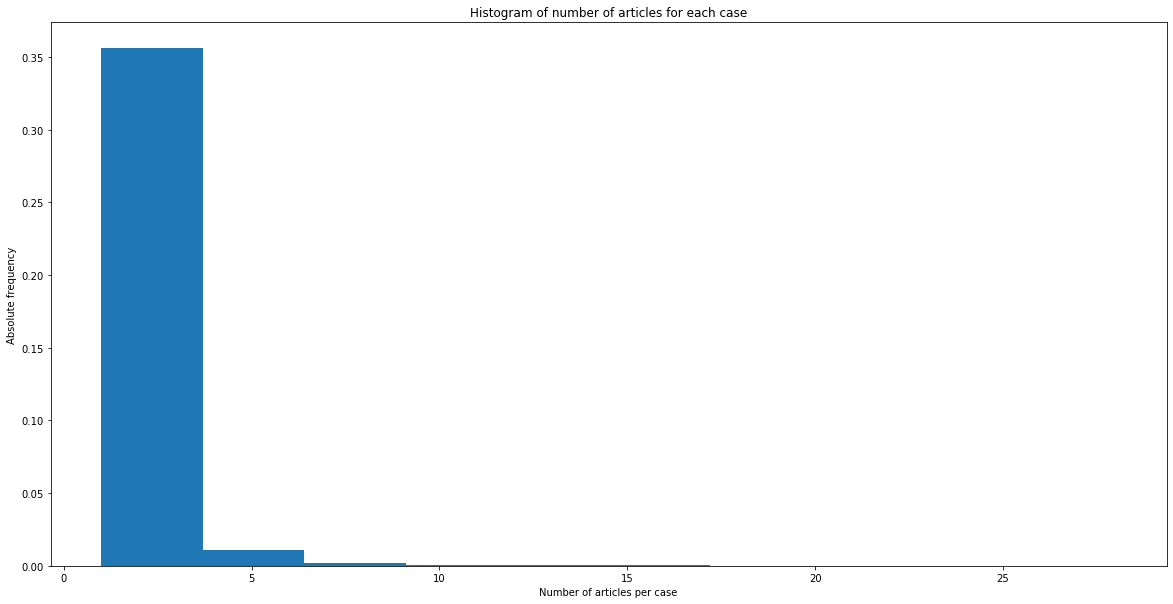

In [25]:
import matplotlib.pyplot as plt 

len_cluster = {}
for cluster in clusters_df.iterrows():
    try:
        len_cluster[cluster[1]['cluster_id']] += 1
    except:
        len_cluster[cluster[1]['cluster_id']] = 1
        
f = plt.figure(figsize = (20,10))
plt.title('Histogram of number of articles for each case')
plt.hist(x=len_cluster.values(), density=True)
plt.xlabel('Number of articles per case')
plt.ylabel('Absolute frequency')
plt.show()

In [35]:
clusters = []
for cluster in len_cluster.keys():
    if len_cluster[cluster] != 1:
        clusters.append(cluster)

1625


In [41]:
# IMPORT INFORMATION ABOUT ARTICLES
data, repeated_data = create_articles_dictionary(NEWS_PATH)

articles_df = pd.DataFrame()

for media in data.keys():
    for new in data[media]:
        tweet_id = new['id']
        title = normalize_string(new['title'])
        headline = normalize_string(new['headline'])
        url = new['url']
        publication_date = new['publication_date']
        article = normalize_string(new['article'])
        
        articles_df = articles_df.append({'tweet_id': tweet_id, 'media': media, 'title': title, 
                                          'headline': headline, 'url': url, 'publication_date': publication_date,
                                          'article': article},
                                       ignore_index=True)

In [47]:
times = {}
for c in clusters:
    c_df = clusters_df[clusters_df['cluster_id']==c]
    for row in c_df.iterrows():
        try:
            times[c].append(articles_df[articles_df['tweet_id']==row[1]['tweet_id']]['publication_date'].values)
        except:
            times[c] = []
            times[c].append(articles_df[articles_df['tweet_id']==row[1]['tweet_id']]['publication_date'].values)

In [66]:
time_len_cases = {}
for case in times:
    dif = 1
    for i in range(0, len(times[case])-1):
        if (abs(times[case][i][0] - times[case][i+1][0])/np.timedelta64(1,'D')) > dif:
            dif = abs(times[case][i][0] - times[case][i+1][0])/np.timedelta64(1,'D')
    time_len_cases[case] = dif

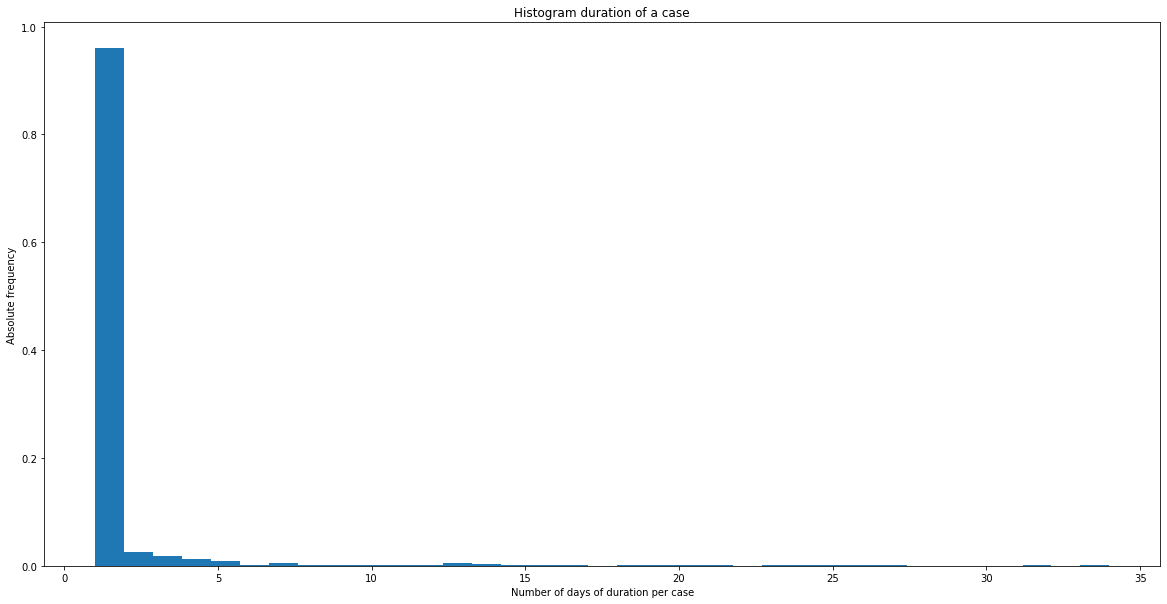

In [70]:
f = plt.figure(figsize = (20,10))
plt.title('Histogram duration of a case')
plt.hist(x=time_len_cases.values(), bins = 35, density=True)
plt.xlabel('Number of days of duration per case')
plt.ylabel('Absolute frequency')
plt.show()

# 1. REGULAR EXPRESSIONS 
Check presence of regular expressions in articles
### Import articles and update regular expressions

In [129]:
# IMPORT INFORMATION ABOUT ARTICLES
data, repeated_data = create_articles_dictionary(NEWS_PATH)

In [244]:
# UPDATE CATEGORIES - REGULAR EXPRESSIONS' DICT 
# categories is a dictionary with regular expressions imported from `utilities.regex_categories`
nacionalidades = []
filename = 'utilities/nacionalidades.txt'
file = open(filename, 'r')

for line in file:
    string = line.split(' - ')[-1].split('\n')[0][:-1] #remove last char that may insert gender
    nacionalidades.append(normalize_string(string))

categories['STIGMA_ORIGIN'] = categories['STIGMA_ORIGIN'] + nacionalidades

### Create a dataset with the presence frequency of each category 

In [245]:
# CREATE DATASET TO STORE REGULAR EXPRESSIONS' OCCURRENCES IN EACH ARTICLE
dataset = pd.DataFrame()

# Append identificator: tweet_id 
tweet_ids = []
for media, articles in data.items():
    for element in articles: 
        tweet_ids.append(element['id'])
dataset.insert(0, 'tweet_id', tweet_ids)

In [246]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14961 entries, 0 to 14960
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  14961 non-null  object
dtypes: object(1)
memory usage: 117.0+ KB


In [247]:
# Check for each category the number of times each category is mentioned
for key, categ_list in categories.items():
    general_results = []
    title_results = []
    summary_results = []
    article_results = []

    pos = 0  # Keep track of position to assert correct tweet_id
    for media, articles in data.items():
        for i, element in enumerate(articles):
            assert(tweet_ids[pos] == element['id'])
            total_title = 0
            total_summary = 0
            total_article = 0
                        
            for categ in categ_list:
                total_title += len(re.findall(categ, element['title']))
                total_summary += len(re.findall(categ, element['headline']))
                total_article += len(re.findall(categ, element['article']))
                            
            title_results.append(total_title)
            summary_results.append(total_summary)
            article_results.append(total_article)
            general_results.append(int(bool(total_title or total_summary or total_article)))
            pos += 1
            
    dataset.insert(len(dataset.columns), f'''{key}_bool''', general_results)
    dataset.insert(len(dataset.columns), f'''{key}_title''', title_results)
    dataset.insert(len(dataset.columns), f'''{key}_summary''', summary_results)
    dataset.insert(len(dataset.columns), f'''{key}_article''', article_results)

In [248]:
dataset.head()

,tweet_id,AGE_bool,AGE_title,AGE_summary,AGE_article,SEXUAL_ASSAULT_bool,SEXUAL_ASSAULT_title,SEXUAL_ASSAULT_summary,SEXUAL_ASSAULT_article,SEXUAL_HARASSMENT_bool,SEXUAL_HARASSMENT_title,SEXUAL_HARASSMENT_summary,SEXUAL_HARASSMENT_article,SEXUAL_ABUSE_bool,SEXUAL_ABUSE_title,SEXUAL_ABUSE_summary,SEXUAL_ABUSE_article,BOND_RELATIONSHIP_bool,BOND_RELATIONSHIP_title,BOND_RELATIONSHIP_summary,BOND_RELATIONSHIP_article,BOND_RELATIVE_bool,BOND_RELATIVE_title,BOND_RELATIVE_summary,BOND_RELATIVE_article,BOND_KNOWN_bool,BOND_KNOWN_title,BOND_KNOWN_summary,BOND_KNOWN_article,PLACE_PUBLIC_bool,PLACE_PUBLIC_title,PLACE_PUBLIC_summary,PLACE_PUBLIC_article,PLACE_WORKPLACE_bool,PLACE_WORKPLACE_title,PLACE_WORKPLACE_summary,PLACE_WORKPLACE_article,PLACE_HOUSE_bool,PLACE_HOUSE_title,PLACE_HOUSE_summary,PLACE_HOUSE_article,PLACE_EDUCATIONAL_bool,PLACE_EDUCATIONAL_title,PLACE_EDUCATIONAL_summary,PLACE_EDUCATIONAL_article,PLACE_LEISURE_bool,PLACE_LEISURE_title,PLACE_LEISURE_summary,PLACE_LEISURE_article,TIME_bool,TIME_title,TIME_summary,TIME_article,STIGMA_INTOXICATED_bool,STIGMA_INTOXICATED_title,STIGMA_INTOXICATED_summary,STIGMA_INTOXICATED_article,STIGMA_CLOTHING_bool,STIGMA_CLOTHING_title,STIGMA_CLOTHING_summary,STIGMA_CLOTHING_article,STIGMA_ORIGIN_bool,STIGMA_ORIGIN_title,STIGMA_ORIGIN_summary,STIGMA_ORIGIN_article,STIGMA_AGGRESSOR_bool,STIGMA_AGGRESSOR_title,STIGMA_AGGRESSOR_summary,STIGMA_AGGRESSOR_article,STIGMA_VULNERABILITY_bool,STIGMA_VULNERABILITY_title,STIGMA_VULNERABILITY_summary,STIGMA_VULNERABILITY_article,EXPRESSION_EUPHEMISM_bool,EXPRESSION_EUPHEMISM_title,EXPRESSION_EUPHEMISM_summary,EXPRESSION_EUPHEMISM_article,EXPRESSION_DOUBT_bool,EXPRESSION_DOUBT_title,EXPRESSION_DOUBT_summary,EXPRESSION_DOUBT_article
0,1303291580548341766,1,0,0,6,1,1,1,3,0,0,0,0,1,0,0,1,1,1,0,1,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,1,1,0,1
1,1308342870210994176,1,0,1,6,1,1,0,2,1,1,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,2,0,0,0,0,1,0,0,6,0,0,0,0,1,0,0,2,1,0,0,1,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1304400864250130432,1,0,1,2,1,1,1,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3
3,1303669508926771200,1,0,2,10,1,0,1,1,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,16,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0
4,1308938267182747648,1,2,3,18,1,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,17,0,0,0,0,1,1,1,1


### Add cluster

In [249]:
clusters_df = pd.read_csv(INFO_FILE_PATH)
clusters_df = clusters_df[['cluster_id', 'tweet_id']]
clusters_df['tweet_id'] = clusters_df['tweet_id'].apply(lambda x: str(x))

dataset = pd.merge(dataset, clusters_df)

In [250]:
dataset.head()

,tweet_id,AGE_bool,AGE_title,AGE_summary,AGE_article,SEXUAL_ASSAULT_bool,SEXUAL_ASSAULT_title,SEXUAL_ASSAULT_summary,SEXUAL_ASSAULT_article,SEXUAL_HARASSMENT_bool,SEXUAL_HARASSMENT_title,SEXUAL_HARASSMENT_summary,SEXUAL_HARASSMENT_article,SEXUAL_ABUSE_bool,SEXUAL_ABUSE_title,SEXUAL_ABUSE_summary,SEXUAL_ABUSE_article,BOND_RELATIONSHIP_bool,BOND_RELATIONSHIP_title,BOND_RELATIONSHIP_summary,BOND_RELATIONSHIP_article,BOND_RELATIVE_bool,BOND_RELATIVE_title,BOND_RELATIVE_summary,BOND_RELATIVE_article,BOND_KNOWN_bool,BOND_KNOWN_title,BOND_KNOWN_summary,BOND_KNOWN_article,PLACE_PUBLIC_bool,PLACE_PUBLIC_title,PLACE_PUBLIC_summary,PLACE_PUBLIC_article,PLACE_WORKPLACE_bool,PLACE_WORKPLACE_title,PLACE_WORKPLACE_summary,PLACE_WORKPLACE_article,PLACE_HOUSE_bool,PLACE_HOUSE_title,PLACE_HOUSE_summary,PLACE_HOUSE_article,PLACE_EDUCATIONAL_bool,PLACE_EDUCATIONAL_title,PLACE_EDUCATIONAL_summary,PLACE_EDUCATIONAL_article,PLACE_LEISURE_bool,PLACE_LEISURE_title,PLACE_LEISURE_summary,PLACE_LEISURE_article,TIME_bool,TIME_title,TIME_summary,TIME_article,STIGMA_INTOXICATED_bool,STIGMA_INTOXICATED_title,STIGMA_INTOXICATED_summary,STIGMA_INTOXICATED_article,STIGMA_CLOTHING_bool,STIGMA_CLOTHING_title,STIGMA_CLOTHING_summary,STIGMA_CLOTHING_article,STIGMA_ORIGIN_bool,STIGMA_ORIGIN_title,STIGMA_ORIGIN_summary,STIGMA_ORIGIN_article,STIGMA_AGGRESSOR_bool,STIGMA_AGGRESSOR_title,STIGMA_AGGRESSOR_summary,STIGMA_AGGRESSOR_article,STIGMA_VULNERABILITY_bool,STIGMA_VULNERABILITY_title,STIGMA_VULNERABILITY_summary,STIGMA_VULNERABILITY_article,EXPRESSION_EUPHEMISM_bool,EXPRESSION_EUPHEMISM_title,EXPRESSION_EUPHEMISM_summary,EXPRESSION_EUPHEMISM_article,EXPRESSION_DOUBT_bool,EXPRESSION_DOUBT_title,EXPRESSION_DOUBT_summary,EXPRESSION_DOUBT_article,cluster_id
0,1303291580548341766,1,0,0,6,1,1,1,3,0,0,0,0,1,0,0,1,1,1,0,1,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,1,1,0,1,2727
1,1308342870210994176,1,0,1,6,1,1,0,2,1,1,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,2,0,0,0,0,1,0,0,6,0,0,0,0,1,0,0,2,1,0,0,1,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2911
2,1304400864250130432,1,0,1,2,1,1,1,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,2789
3,1303669508926771200,1,0,2,10,1,0,1,1,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,16,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,2744
4,1308938267182747648,1,2,3,18,1,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,17,0,0,0,0,1,1,1,1,2929


In [251]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14961 entries, 0 to 14960
Data columns (total 82 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   tweet_id                      14961 non-null  object
 1   AGE_bool                      14961 non-null  int64 
 2   AGE_title                     14961 non-null  int64 
 3   AGE_summary                   14961 non-null  int64 
 4   AGE_article                   14961 non-null  int64 
 5   SEXUAL_ASSAULT_bool           14961 non-null  int64 
 6   SEXUAL_ASSAULT_title          14961 non-null  int64 
 7   SEXUAL_ASSAULT_summary        14961 non-null  int64 
 8   SEXUAL_ASSAULT_article        14961 non-null  int64 
 9   SEXUAL_HARASSMENT_bool        14961 non-null  int64 
 10  SEXUAL_HARASSMENT_title       14961 non-null  int64 
 11  SEXUAL_HARASSMENT_summary     14961 non-null  int64 
 12  SEXUAL_HARASSMENT_article     14961 non-null  int64 
 13  SEXUAL_ABUSE_boo

# 2. CASES ANALYSIS

The following characteristics of each case are determined according to the presence of regular expressions in articles: 
- type of sexual violence
- victim-perpetrator bond
- place where the offence took place

## Type of sexual violence: harrassment, assault and abuse 
**Rules definition**

In [252]:
# RULES DEFINITION
def violence_rules(violence_type, assault, harrassment, abuse): 
    if assault == abuse == 0 and harrassment > 0: 
        violence_type['harassment'] += 1
        type_ = 'harassment'
    
    elif abuse == 0 and assault > 0: 
        violence_type['assault'] += 1
        type_ = 'assault'
    
    elif abuse > 0: 
        violence_type['abuse'] += 1
        type_ = 'abuse'

    else:
        return None, None
    
    return violence_type, type_

**Assessment**

In [253]:
violence_type = {
    'assault': 0,    
    'abuse': 0,      
    'harassment': 0  
}

not_classified = []
general_dict = {}
columns = [col for col in dataset.columns if 'SEXUAL_' in col]

for cluster_id, group in dataset[['cluster_id'] + columns].groupby(by='cluster_id'):
    # Check type of sexual assault
    assault = group['SEXUAL_ASSAULT_bool'].sum()
    harassment = group['SEXUAL_HARASSMENT_bool'].sum()
    abuse = group['SEXUAL_ABUSE_bool'].sum()
    
    aux_dict, aux_type = violence_rules(violence_type, assault, harassment, abuse)
    if aux_dict: 
        violence_type = aux_dict
        general_dict[cluster_id] = {'type': aux_type}
        continue
    
    # If not found, check considering only the title
    title_assault = group['SEXUAL_ASSAULT_title'].sum()
    title_harassment = group['SEXUAL_HARASSMENT_title'].sum()
    title_abuse = group['SEXUAL_ABUSE_title'].sum()
    
    aux_dict, aux_type = violence_rules(violence_type, title_assault, title_harassment, title_abuse)
    if aux_dict: 
        violence_type = aux_dict
        general_dict[cluster_id] = {'type': aux_type}    
    else:
        not_classified.append([harassment, abuse, assault, f'''{cluster_id} - {len(group)}'''])    

In [254]:
# Print statistics about the results
total_detected = sum(violence_type.values())
total = total_detected + len(not_classified)

print(f'''Total clusters classified: {total_detected} -- Clusters left out: {len(not_classified)}''')
print(f'''* Assault cases detected: {violence_type['assault']} which represent {round(violence_type['assault']/total*100, 3)}%''')
print(f'''* Abuse cases detected: {violence_type['abuse']} which represent {round(violence_type['abuse']/total*100, 3)}%''')
print(f'''* Harassment cases detected: {violence_type['harassment']} which represent {round(violence_type['harassment']/total*100, 3)}%''')
print(f'''Clusters not classified: {len(not_classified)} which represent {round(len(not_classified)/total*100, 3)}%''')

Total clusters classified: 10331 -- Clusters left out: 955
* Assault cases detected: 3027 which represent 26.821%
* Abuse cases detected: 6640 which represent 58.834%
* Harassment cases detected: 664 which represent 5.883%
Clusters not classified: 955 which represent 8.462%


**Display conflictive cases that could not be classified**

In [255]:
pd.DataFrame(data=not_classified, columns = ['Harassment', 'Abuse', 'Assault', 'Cluster id - size']).head(20)

,Harassment,Abuse,Assault,Cluster id - size
0,0,0,0,0 - 1
1,0,0,0,3 - 1
2,0,0,0,10 - 1
3,0,0,0,40 - 1
4,0,0,0,57 - 1
5,0,0,0,184 - 1
6,0,0,0,193 - 1
7,0,0,0,200 - 1
8,0,0,0,226 - 1
9,0,0,0,243 - 1


## Relationship between the victim and the aggressor

**Rules definition**

In [256]:
# RULES DEFINITION
def rules(bond, relationship, relative, known):    
    # If none -> stranger
    if relationship == relative == known == 0:
        bond['stranger'] += 1
        type_ = 'stranger'
    
    # If only one -> then, that one
    elif relationship == relative == 0 and known > 0:
        bond['known'] += 1
        type_ = 'known'
    
    elif relationship == known == 0 and relative > 0:
        bond['relative'] += 1
        type_ = 'relative'
    
    elif known == relative == 0 and relationship > 0:
        bond['relationship'] += 1
        type_ = 'relationship'
    
    # If maximum is relationship -> relationship
    elif relationship > relative and relationship > known:
        bond['relationship'] += 1
        type_ = 'relationship'
        
    else:
        return None, None
    return bond, type_

**Assessment**

In [257]:
bond = {
    'relationship': 0,
    'relative': 0,
    'known': 0,
    'stranger': 0
}
not_classified = []

columns = [col for col in dataset.columns if 'BOND_' in col]
for cluster_id, group in dataset[['cluster_id']+columns].groupby(by='cluster_id'):
    relationship = group['BOND_RELATIONSHIP_bool'].sum()
    relative = group['BOND_RELATIVE_bool'].sum()
    known = group['BOND_KNOWN_bool'].sum()
    
    aux_dict, aux_type = rules(bond, relationship, relative, known)
    if aux_dict: 
        bond = aux_dict # Update bond dictionary
        try: 
            general_dict[cluster_id]['bond'] = aux_type
        except:
            general_dict[cluster_id] = {'type': None,
                                       'bond': aux_type}
        continue   # And quit the loop
    
    # Else, check only title
    title_relationship = group['BOND_RELATIONSHIP_title'].sum()
    title_relative = group['BOND_RELATIVE_title'].sum()
    title_known = group['BOND_KNOWN_title'].sum()
    
    aux_dict, aux_type = rules(bond, title_relationship, title_relative, title_known)
    if aux_dict:
        bond = aux_dict
        try: 
            general_dict[cluster_id]['bond'] = aux_type
        except:
            general_dict[cluster_id] = {'type': None,
                                       'bond': aux_type}
    else: 
        try:
            general_dict[cluster_id]['bond'] = None
            not_classified.append([known, relative, relationship, f'''{cluster_id} - {len(group)}'''])
        except:
            pass

In [258]:
total_detected = sum(bond.values())
total = total_detected + len(not_classified)
print(f'''Total clusters classified: {total_detected} -- Clusters left out: {len(not_classified)}''')
print(f'''* Relationship cases: {bond['relationship']} which represent {round(bond['relationship']/total*100, 3)}%''')
print(f'''* Relative agressor: {bond['relative']} which represent {round(bond['relative']/total*100, 3)}%''')
print(f'''* Known agressor: {bond['known']} which represent {round(bond['known']/total*100, 3)}%''')
print(f'''* Stranger agressor: {bond['stranger']} which represent {round(bond['stranger']/total*100, 3)}%''')
print(f'''Clusters not classified: {len(not_classified)} which represent {round(len(not_classified)/total*100, 3)}%''')

Total clusters classified: 11054 -- Clusters left out: 203
* Relationship cases: 930 which represent 8.262%
* Relative agressor: 1567 which represent 13.92%
* Known agressor: 2909 which represent 25.842%
* Stranger agressor: 5648 which represent 50.173%
Clusters not classified: 203 which represent 1.803%


**Display conflictive cases that could not be classified**

In [259]:
pd.DataFrame(data = not_classified, columns = ['Known', 'Relative', 'Relationship', 'Cluster id - size']).head(5)

,Known,Relative,Relationship,Cluster id - size
0,1,1,0,35 - 1
1,3,0,3,94 - 3
2,1,1,1,121 - 1
3,0,1,1,166 - 1
4,0,1,1,296 - 1


## Place where sexual offences occur

**Assessment**

In [260]:
type_place = {
    'public': 0,
    'workplace': 0,
    'house': 0,
    'education': 0,
    'leisure': 0
}
not_classified = []
positions = dict(zip(range(5), ['public', 'workplace', 'house', 'education', 'leisure'])) 

columns = [col for col in dataset.columns if 'PLACE_' in col]
for cluster_id, group in dataset[['cluster_id']+columns].groupby(by='cluster_id'):
    # If bond is relationship, skip cluster
    try:
        if general_dict[cluster_id]['bond'] == 'relationship':
            general_dict[cluster_id]['place'] = None
            continue

        case_places = {
            'public': {
                'bool':group['PLACE_PUBLIC_bool'].sum(),
                'title': group['PLACE_PUBLIC_title'].sum(),
                'summary': group['PLACE_PUBLIC_summary'].sum(),
                'article': group['PLACE_PUBLIC_article'].sum()
            },
            'workplace': {
                'bool':group['PLACE_WORKPLACE_bool'].sum(),
                'title': group['PLACE_WORKPLACE_title'].sum(),
                'summary': group['PLACE_WORKPLACE_summary'].sum(),
                'article': group['PLACE_WORKPLACE_article'].sum()
            },
            'house': {
                'bool':group['PLACE_HOUSE_bool'].sum(),
                'title': group['PLACE_HOUSE_title'].sum(),
                'summary': group['PLACE_HOUSE_summary'].sum(),
                'article': group['PLACE_HOUSE_article'].sum()
                },
            'education': {
                'bool':group['PLACE_EDUCATIONAL_bool'].sum(),
                'title': group['PLACE_EDUCATIONAL_title'].sum(),
                'summary': group['PLACE_EDUCATIONAL_summary'].sum(),
                'article': group['PLACE_EDUCATIONAL_article'].sum()
                },
            'leisure': {
                'bool':group['PLACE_LEISURE_bool'].sum(),
                'title': group['PLACE_LEISURE_title'].sum(),
                'summary': group['PLACE_LEISURE_summary'].sum(),
                'article': group['PLACE_LEISURE_article'].sum()
                }
        }

        # CHECK BOOL FIRST
        places = []
        for key, value in case_places.items(): places.append(value['bool'])
        max_pos = list(np.flatnonzero(places == np.max(places)))
        if len(max_pos) == 1:
            type_place[positions[max_pos[0]]] += 1
            general_dict[cluster_id]['place'] = positions[max_pos[0]]
            continue 

        # CHECK TITLE + SUMMARY
        places = []
        for key, value in case_places.items(): places.append(value['title']+value['summary'])
        max_pos = list(np.flatnonzero(places == np.max(places)))
        if len(max_pos) == 1:
            type_place[positions[max_pos[0]]] += 1
            general_dict[cluster_id]['place'] = positions[max_pos[0]]
            continue 

        # CHECK ARTICLE'S BODY
        places = []
        for key, value in case_places.items(): places.append(value['article'])
        max_pos = list(np.flatnonzero(places == np.max(places)))
        if len(max_pos) == 1:
            type_place[positions[max_pos[0]]] += 1
            general_dict[cluster_id]['place'] = positions[max_pos[0]]
            continue 

        not_classified.append([case_places['public']['bool'], case_places['workplace']['bool'],
                             case_places['house']['bool'], case_places['education']['bool'],
                             case_places['leisure']['bool'], f'''{cluster_id} - {len(group)}'''])
        general_dict[cluster_id]['place'] = None
    except:
        pass

In [261]:
total_detected = sum(type_place.values())
print(f'''Total clusters classified: {total_detected} -- Clusters left out: {len(not_classified)} ''')
print(f'''Public places: {type_place['public']} which represent {round(type_place['public']/total*100, 3)}%''')
print(f'''House: {type_place['house']} which represent {round(type_place['house']/total*100, 3)}%''')
print(f'''Workplace: {type_place['workplace']} which represent {round(type_place['workplace']/total*100, 3)}%''')
print(f'''Educational place: {type_place['education']} which represent {round(type_place['education']/total*100, 3)}%''')
print(f'''Leisure place: {type_place['leisure']} which represent {round(type_place['leisure']/total*100, 3)}%''')
print(f'''Clusters not classified: {len(not_classified)} which represent {round(len(not_classified)/total*100, 3)}%''')

Total clusters classified: 9027 -- Clusters left out: 1300 
Public places: 4899 which represent 43.52%
House: 1207 which represent 10.722%
Workplace: 219 which represent 1.945%
Educational place: 261 which represent 2.319%
Leisure place: 2441 which represent 21.684%
Clusters not classified: 1300 which represent 11.548%


In [262]:
general_dict

{1: {'type': 'abuse', 'bond': 'stranger', 'place': 'leisure'},
 2: {'type': 'harassment', 'bond': 'stranger', 'place': 'leisure'},
 4: {'type': 'abuse', 'bond': 'relative', 'place': 'leisure'},
 5: {'type': 'abuse', 'bond': 'stranger', 'place': 'public'},
 6: {'type': 'assault', 'bond': 'known', 'place': None},
 7: {'type': 'harassment', 'bond': 'known', 'place': 'leisure'},
 8: {'type': 'abuse', 'bond': 'stranger', 'place': 'public'},
 9: {'type': 'abuse', 'bond': 'known', 'place': 'public'},
 11: {'type': 'assault', 'bond': 'stranger', 'place': 'leisure'},
 12: {'type': 'abuse', 'bond': 'relative', 'place': 'public'},
 13: {'type': 'assault', 'bond': 'stranger', 'place': 'leisure'},
 14: {'type': 'assault', 'bond': 'relative', 'place': 'house'},
 15: {'type': 'abuse', 'bond': 'stranger', 'place': 'public'},
 16: {'type': 'assault', 'bond': 'known', 'place': 'house'},
 17: {'type': 'assault', 'bond': 'stranger', 'place': 'leisure'},
 18: {'type': 'assault', 'bond': 'relative', 'place'

**Display conflictive cases that could not be classified**

In [263]:
pd.DataFrame(data = not_classified, columns = ['Public', 'Workplace', 'House', 'Educational', 'Leisure', 'Cluster id - size']).head(5)

,Public,Workplace,House,Educational,Leisure,Cluster id - size
0,0,0,0,0,0,6 - 1
1,0,0,0,0,0,10 - 1
2,1,0,1,0,1,26 - 1
3,4,0,0,0,4,38 - 4
4,1,0,1,0,1,39 - 1


## Assign characteristics to each case and compute frequency statistics

In [264]:
# CREATE DATAFRAME WITH type, bond, and place for each chase id
general_df = pd.DataFrame.from_dict(data=general_dict, orient = 'index').reset_index().rename(columns = {'index': 'case_id'})
cluster_size_df = pd.DataFrame(clusters_df['cluster_id'].value_counts()).reset_index().rename(columns = {'index': 'case_id', 'cluster_id': 'cluster_size'})
general_df = general_df.merge(cluster_size_df, on='case_id')
general_df = general_df[general_df['cluster_size']>1]

In [265]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14961 entries, 0 to 14960
Data columns (total 82 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   tweet_id                      14961 non-null  object
 1   AGE_bool                      14961 non-null  int64 
 2   AGE_title                     14961 non-null  int64 
 3   AGE_summary                   14961 non-null  int64 
 4   AGE_article                   14961 non-null  int64 
 5   SEXUAL_ASSAULT_bool           14961 non-null  int64 
 6   SEXUAL_ASSAULT_title          14961 non-null  int64 
 7   SEXUAL_ASSAULT_summary        14961 non-null  int64 
 8   SEXUAL_ASSAULT_article        14961 non-null  int64 
 9   SEXUAL_HARASSMENT_bool        14961 non-null  int64 
 10  SEXUAL_HARASSMENT_title       14961 non-null  int64 
 11  SEXUAL_HARASSMENT_summary     14961 non-null  int64 
 12  SEXUAL_HARASSMENT_article     14961 non-null  int64 
 13  SEXUAL_ABUSE_boo

In [266]:
def create_summary_df(original_df, key, total_cases, total_articles):
    output_df = pd.DataFrame(columns = ['Type', 'Number of cases', 'Percentage of cases', 'Number of articles', 'Percentage of articles'])
    
    for value, group in general_df.groupby(by=key):
        output_df = output_df.append({'Type': value,
                                      'Number of cases': len(group),
                                      'Percentage of cases': len(group)/total_cases*100,
                                      'Number of articles': group['cluster_size'].sum(),
                                      'Percentage of articles': group['cluster_size'].sum()/total_articles*100},
                                      ignore_index = True)
    not_classified = general_df[general_df[key].isna()]
    if key == 'place':
        not_classified = general_df[(general_df[key].isna()) & (general_df['bond'] != 'relationship')]
    output_df = output_df.append({'Type': None,
                                      'Number of cases': len(not_classified),
                                      'Percentage of cases': len(not_classified)/total_cases*100,
                                      'Number of articles': not_classified['cluster_size'].sum(),
                                      'Percentage of articles': not_classified['cluster_size'].sum()/total_articles*100},
                                      ignore_index = True)
    return output_df

In [267]:
total_cases = len(general_df)
total_articles = len(dataset.tweet_id.unique())
type_violence_df = create_summary_df(general_df, 'type', total_cases, total_articles)
bond_agressor_df = create_summary_df(general_df, 'bond', total_cases, total_articles)
place_df = create_summary_df(general_df, 'place', total_cases, total_articles)

In [268]:
type_violence_df

,Type,Number of cases,Percentage of cases,Number of articles,Percentage of articles
0,abuse,1118,68.92725,3863,25.820467
1,assault,392,24.167694,1117,7.466078
2,harassment,65,4.007398,199,1.330125
3,NaN,47.0,2.897657,114.0,0.761981


In [269]:
bond_agressor_df

,Type,Number of cases,Percentage of cases,Number of articles,Percentage of articles
0,known,501,30.887793,1670,11.162355
1,relationship,149,9.18619,460,3.074661
2,relative,232,14.303329,699,4.672148
3,stranger,686,42.293465,2236,14.945525
4,NaN,54.0,3.329223,228.0,1.523962


In [270]:
place_df

,Type,Number of cases,Percentage of cases,Number of articles,Percentage of articles
0,education,40,2.466091,144,0.962503
1,house,185,11.405672,632,4.224317
2,leisure,276,17.01603,930,6.216162
3,public,860,53.020962,2840,18.982688
4,workplace,32,1.972873,91,0.608248
5,NaN,80.0,4.932182,196.0,1.310073


# CONTENT ANALYSIS
Check which information is present in each articles, and the articles' part in which appear (headline, subtitle and body).

## General information
Type of information considered:
- place
- time
- age

In [271]:
# AGGREGATE INFORMATION FROM THE DATASET PREVIOUSLY CREATED
# To avoid running again all the regular expressions
def mentions_info(dataset, key, type_info = '_bool'):
    num_articles = 0
    columns = [col for col in dataset.columns if (key in col) and (type_info in col)]
    for index, row in dataset[['cluster_id']+columns].iterrows():
        if any(row[columns] >= 1):
            num_articles += 1
    return num_articles

In [272]:
information_dict = dict(zip(['TIME', 'AGE',
                             'PLACE_PUBLIC','PLACE_WORKPLACE', 'PLACE_HOUSE', 
                             'PLACE_EDUCATIONAL', 'PLACE_LEISURE', 
                             'BOND_RELATIONSHIP', 'BOND_RELATIVE', 'BOND_KNOWN'], [{}]*10))

for key in information_dict.keys():
    aux_dict = {}
    aux_dict['Total'] = mentions_info(dataset, key+'_')
    aux_dict['Total percentage'] = round(aux_dict['Total']/len(dataset)*100, 4)
    aux_dict['Title'] = mentions_info(dataset, key+'_', '_title')
    aux_dict['Title percentage'] = round(aux_dict['Title']/len(dataset)*100, 4)
    aux_dict['Summary'] = mentions_info(dataset, key+'_', '_summary')
    aux_dict['Summary percentage'] = round(aux_dict['Summary']/len(dataset)*100, 4)
    aux_dict['Article'] = mentions_info(dataset, key+'_', '_article')
    aux_dict['Article percentage'] = round(aux_dict['Article']/len(dataset)*100, 4)
    information_dict[key] = aux_dict

In [273]:
information_df = pd.DataFrame.from_dict(data=information_dict, orient='index')
information_df

,Total,Total percentage,Title,Title percentage,Summary,Summary percentage,Article,Article percentage
TIME,3691,24.6708,44,0.2941,252,1.6844,3677,24.5772
AGE,14185,94.8132,6037,40.3516,5829,38.9613,14088,94.1648
PLACE_PUBLIC,11940,79.8075,4636,30.9872,2942,19.6645,11748,78.5242
PLACE_WORKPLACE,3193,21.3422,114,0.7620,188,1.2566,3169,21.1817
PLACE_HOUSE,7489,50.0568,443,2.9610,919,6.1426,7437,49.7092
PLACE_EDUCATIONAL,2303,15.3934,265,1.7713,307,2.0520,2250,15.0391
PLACE_LEISURE,10689,71.4458,880,5.8820,1327,8.8697,10561,70.5902
BOND_RELATIONSHIP,4132,27.6185,825,5.5143,607,4.0572,4077,27.2509
BOND_RELATIVE,6009,40.1644,1344,8.9834,1261,8.4286,5950,39.7701
BOND_KNOWN,8246,55.1166,959,6.4100,1262,8.4353,8157,54.5218


## Stigmas
Type of information considered:
- stigmas intoxicated
- stigmas about clothing
- stigmas about the origin
- stigmas about the perpetrator
- mentions of vulnerability

In [274]:
stigmas_dict = dict(zip(['STIGMA_INTOXICATED', 'STIGMA_CLOTHING', 'STIGMA_ORIGIN', 'STIGMA_AGGRESSOR', 'STIGMA_VULNERABILITY'], [{}]*5))

for key in stigmas_dict.keys(): 
    aux_dict = {}
    aux_dict['Total'] = mentions_info(dataset, key+'_')
    aux_dict['Total percentage'] = round(aux_dict['Total']/len(dataset)*100, 4)
    aux_dict['Title'] = mentions_info(dataset, key+'_', '_title')
    aux_dict['Title percentage'] = round(aux_dict['Title']/len(dataset)*100, 4)
    aux_dict['Summary'] = mentions_info(dataset, key+'_', '_summary')
    aux_dict['Summary percentage'] = round(aux_dict['Summary']/len(dataset)*100, 4)
    aux_dict['Article'] = mentions_info(dataset, key+'_', '_article')
    aux_dict['Article percentage'] = round(aux_dict['Article']/len(dataset)*100, 4)
    stigmas_dict[key] = aux_dict

In [275]:
stigmas_df = pd.DataFrame.from_dict(data=stigmas_dict, orient='index')
stigmas_df

,Total,Total percentage,Title,Title percentage,Summary,Summary percentage,Article,Article percentage
STIGMA_INTOXICATED,2525,16.8772,213,1.4237,289,1.9317,2495,16.6767
STIGMA_CLOTHING,1931,12.9069,51,0.3409,125,0.8355,1909,12.7598
STIGMA_ORIGIN,7020,46.9220,700,4.6788,913,6.1025,6919,46.2469
STIGMA_AGGRESSOR,745,4.9796,125,0.8355,58,0.3877,708,4.7323
STIGMA_VULNERABILITY,11482,76.7462,4197,28.0529,3436,22.9664,11317,75.6433


## Expression
Type of information considered:
- Euphemisms
- Doubt-related expressions
- Type of sexual violence 

In [276]:
expression_dict = dict(zip(['EXPRESSION_EUPHEMISM', 'EXPRESSION_DOUBT', 'SEXUAL_ASSAULT', 'SEXUAL_HARASSMENT', 'SEXUAL_ABUSE'], [{}]*5))

for key in expression_dict.keys(): 
    aux_dict = {}
    aux_dict['Total'] = mentions_info(dataset, key+'_')
    aux_dict['Total percentage'] = round(aux_dict['Total']/len(dataset)*100, 4)
    aux_dict['Title'] = mentions_info(dataset, key+'_', '_title')
    aux_dict['Title percentage'] = round(aux_dict['Title']/len(dataset)*100, 4)
    aux_dict['Summary'] = mentions_info(dataset, key+'_', '_summary')
    aux_dict['Summary percentage'] = round(aux_dict['Summary']/len(dataset)*100, 4)
    aux_dict['Article'] = mentions_info(dataset, key+'_', '_article')
    aux_dict['Article percentage'] = round(aux_dict['Article']/len(dataset)*100, 4)
    expression_dict[key] = aux_dict

In [277]:
expression_df = pd.DataFrame.from_dict(data=expression_dict, orient='index')
expression_df

,Total,Total percentage,Title,Title percentage,Summary,Summary percentage,Article,Article percentage
EXPRESSION_EUPHEMISM,2148,14.3573,16,0.1069,105,0.7018,2134,14.2638
EXPRESSION_DOUBT,8020,53.6060,1729,11.5567,1623,10.8482,7742,51.7479
SEXUAL_ASSAULT,9480,63.3647,5030,33.6207,3121,20.8609,9239,61.7539
SEXUAL_HARASSMENT,5151,34.4295,1072,7.1653,926,6.1894,5073,33.9082
SEXUAL_ABUSE,8961,59.8957,4906,32.7919,2544,17.0042,8662,57.8972


**Store all the results**

In [278]:
general_df =  information_df.append(stigmas_df).append(expression_df)

In [279]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, TIME to SEXUAL_ABUSE
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Total               20 non-null     int64  
 1   Total percentage    20 non-null     float64
 2   Title               20 non-null     int64  
 3   Title percentage    20 non-null     float64
 4   Summary             20 non-null     int64  
 5   Summary percentage  20 non-null     float64
 6   Article             20 non-null     int64  
 7   Article percentage  20 non-null     float64
dtypes: float64(4), int64(4)
memory usage: 1.4+ KB
